<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/NN%20LSTM%20ARIMA%20prediction%20timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

полезные ссылки:
https://habr.com/ru/articles/495884/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization

In [2]:
#df = pd.read_csv('/kaggle/input/usd-rub-timeseries/UsdRubTime.csv', delimiter=';', decimal='.')

In [67]:
df = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/machinelearning/refs/heads/main/test_datasets/UsdRubTime.csv',delimiter=';', decimal='.')


In [4]:
df.head()

,Close,Data,Position
0,0.988,22.08.1993,1
1,0.993,29.08.1993,8
2,1.000,05.09.1993,15
3,1.020,12.09.1993,22
4,1.300,19.09.1993,29


In [5]:
df_data = pd.to_datetime(df['Data'], dayfirst=True)
df_data.head()

,Data
0,1993-08-22
1,1993-08-29
2,1993-09-05
3,1993-09-12
4,1993-09-19


In [6]:
df_close = pd.DataFrame(df['Close'])
df_close.index = pd.to_datetime(df['Data'], dayfirst=True)
df_close.head()

,Close
Data,
1993-08-22,0.988
1993-08-29,0.993
1993-09-05,1.000
1993-09-12,1.020
1993-09-19,1.300


In [7]:
df.isnull().sum()

,0
Close,0
Data,0
Position,0


In [8]:
df_close.describe()

,Close
count,1542.000000
mean,35.306973
std,21.890677
min,0.988000
25%,25.754750
50%,29.871000
75%,57.287250
max,133.417000


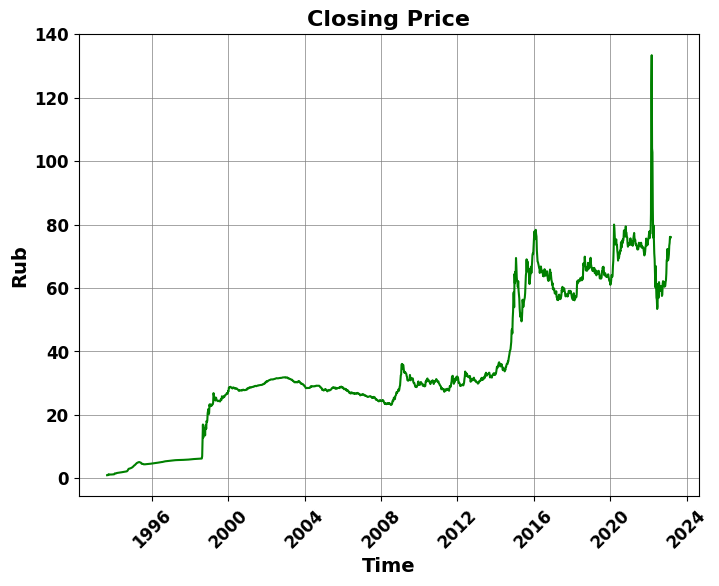

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(df_close, color='g')
plt.title('Closing Price', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Rub', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'grey', linewidth = 0.5)

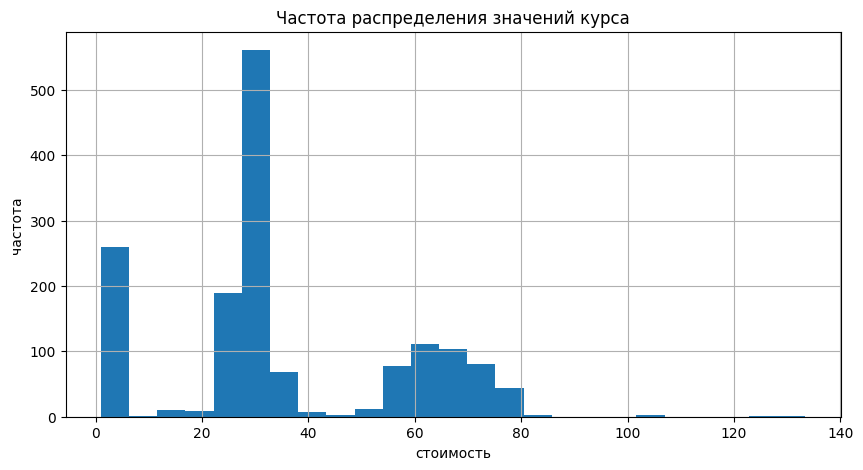

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(df['Close'], bins=25)
plt.title('Частота распределения значений курса')
plt.xlabel('стоимость')
plt.ylabel('частота')
plt.grid(True)
plt.show()

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# Prediction model (one step) - NN LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
df_close[["Close"]] = df_close[["Close"]].values.astype('float32')

train_size = int(len(df_close) * 0.6)
train_data, test_data = df_close[:train_size], df_close[train_size:]

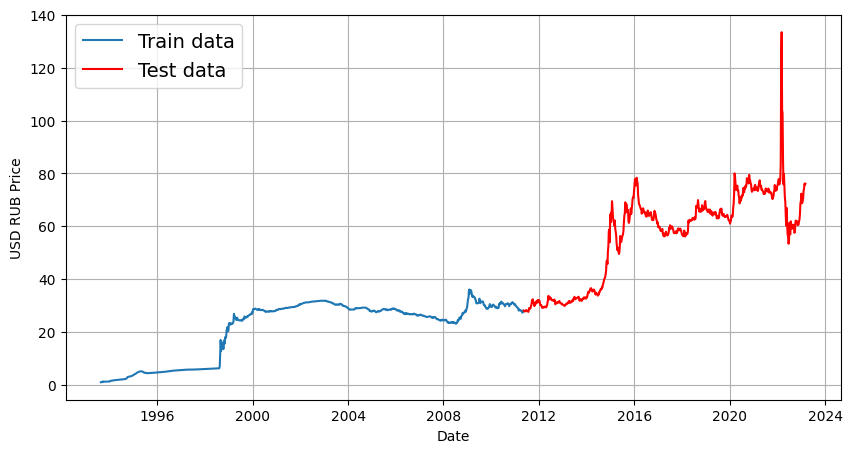

In [ ]:
# Plot correctly made splits

plt.figure(figsize=(10, 5))
plt.plot(train_data['Close'], label="Train data")
plt.plot(test_data['Close'], 'r-', label="Test data")
plt.xlabel("Date")
plt.ylabel("USD RUB Price")
plt.legend(fontsize=14)
plt.grid()
plt.show();

In [ ]:
df_close

,Close
Data,
1993-08-22,0.988000
1993-08-29,0.993000
1993-09-05,1.000000
1993-09-12,1.020000
1993-09-19,1.300000
...,...
2023-02-05,73.348000
2023-02-12,74.230003
2023-02-19,76.135002


In [ ]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Close']])
#scaled_test_data = scaler.transform(test_data[['Close']])
#scaled_test_data = scaler.fit_transform(test_data[['Close']])

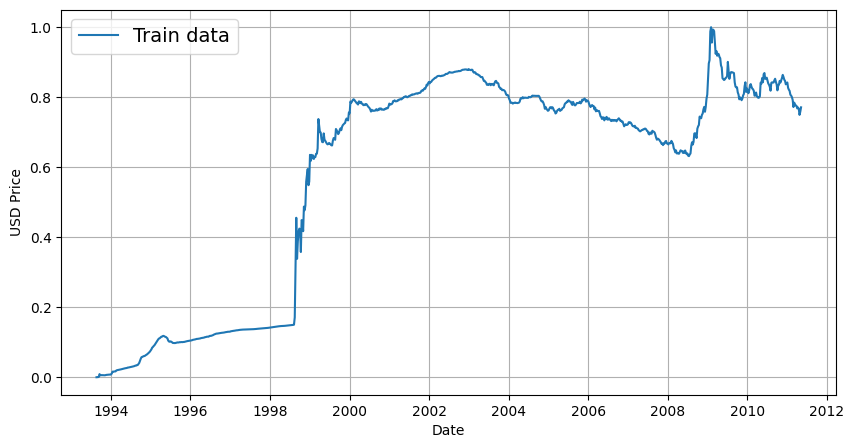

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_data['Close'].index, scaled_train_data, label="Train data")
#plt.plot(test_data['Close'].index, scaled_test_data, 'r-', label="Test data")
plt.xlabel("Date")
plt.ylabel("USD Price")
plt.legend(fontsize=14)
plt.grid()
plt.show();

**epochs**: Обучение разбито на *эпохи*. Эпоха это одна итерация по всем входным данным (это делается небольшими партиями).

**batch_size**: При передаче данных NumPy, модель разбивает данные на меньшие блоки (batches) и итерирует по этим блокам во время обучения. Это число указывает размер каждого блока данных. Помните, что последний блок может быть меньшего размера если общее число записей не делится на размер партии.

In [ ]:
# LSTM model
def create_lstm_model(n_steps):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
      # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
n_steps = 20
# split into samples
X, y = split_sequence(scaled_train_data, n_steps)

In [ ]:
#model = Sequential()
#model.add(LSTM(7, input_shape=(1, 1)))
lstm_model = create_lstm_model(n_steps=n_steps)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
lstm_history = lstm_model.fit(X,y,epochs=10, verbose=1)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3240
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0134
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7099e-04
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7497e-04
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.1691e-04


In [ ]:
scaler.inverse_transform(scaled_train_data[-n_steps:])

array([[30.432999],
       [30.534998],
       [30.003   ],
       [29.813997],
       [29.693   ],
       [29.306   ],
       [29.222   ],
       [29.066998],
       [28.791998],
       [28.075998],
       [28.516998],
       [28.344997],
       [28.229998],
       [28.199999],
       [27.936   ],
       [28.030998],
       [27.91    ],
       [27.284996],
       [27.603998],
       [28.042997]], dtype=float32)

In [ ]:
x_input = scaled_train_data[-n_steps:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = lstm_model.predict(x_input, verbose=1)
print(scaler.inverse_transform(yhat))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
[[28.41176]]


<ipython-input-22-8536b9a855e3>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(test_data['Close'].index[0],test_data['Close'][0],'gx', label = 'True Future')


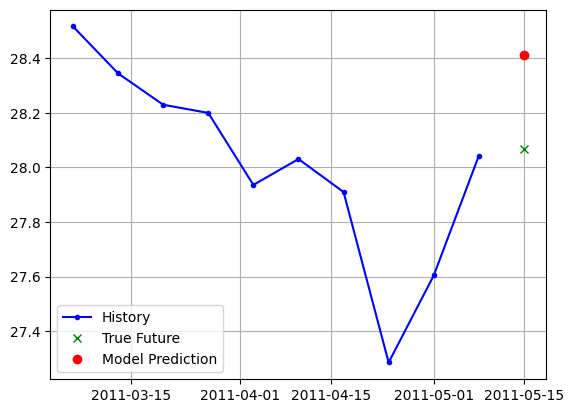

In [ ]:
plt.plot(train_data['Close'].index[-10:],train_data[-10:],'-b.', label = 'History')
plt.plot(test_data['Close'].index[0],test_data['Close'][0],'gx', label = 'True Future')
plt.plot(test_data['Close'].index[0],scaler.inverse_transform(yhat),'ro', label = 'Model Prediction')
plt.legend(loc='best')
plt.grid()


# Prediction model - LSTM self time series

In [ ]:
import torch.nn as nn

class LSTMstepsPretiction(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

In [ ]:
d = {'col1': train_data['Close'].index[:], 'col2': train_data['Close'].values}
df = pd.DataFrame(data=d)

In [ ]:
lookback = 1
X_train, y_train = create_dataset(train_data.values, lookback=lookback)
X_test, y_test = create_dataset(test_data.values, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([924, 1, 1]) torch.Size([924, 1, 1])
torch.Size([616, 1, 1]) torch.Size([616, 1, 1])


In [ ]:
model = LSTMstepsPretiction()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 19.2687, test RMSE 52.9324
Epoch 100: train RMSE 0.4365, test RMSE 23.6404


In [ ]:
plt.rcParams['figure.figsize'] = (17,5)
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df_close.values) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df_close.values) * np.nan
    test_plot[train_size+lookback:len(df_close.values)] = model(X_test)[:, -1, :]
# plot
plt.plot(df_close.values, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.grid()
plt.show()

InvalidArgumentError: Exception encountered when calling LSTMCell.call().

[1m{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [915,1], In[1]: [25,160] [Op:MatMul] name: [0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(915, 1), dtype=float32)
  • states=('tf.Tensor(shape=(915, 40), dtype=float32)', 'tf.Tensor(shape=(915, 40), dtype=float32)')
  • training=False

# Prediction model - NN LSTM loopback

In [ ]:
scaler = MinMaxScaler()
df_close_scaled = scaler.fit_transform(df_close['Close'].values.reshape(-1, 1))
train_size = int(len(df_close_scaled) * 0.6)
train_data, test_data = df_close_scaled[:train_size], df_close_scaled[train_size:]

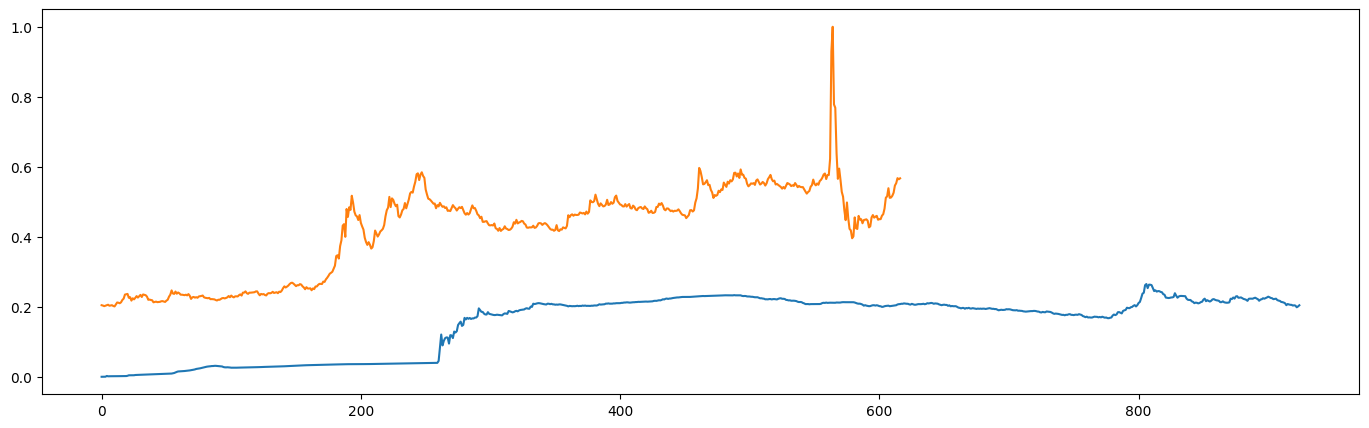

In [ ]:
plt.plot(train_data)
plt.plot(test_data)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=25):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train_data, look_back=25)
x_test, y_test = create_dataset(test_data, look_back=25)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

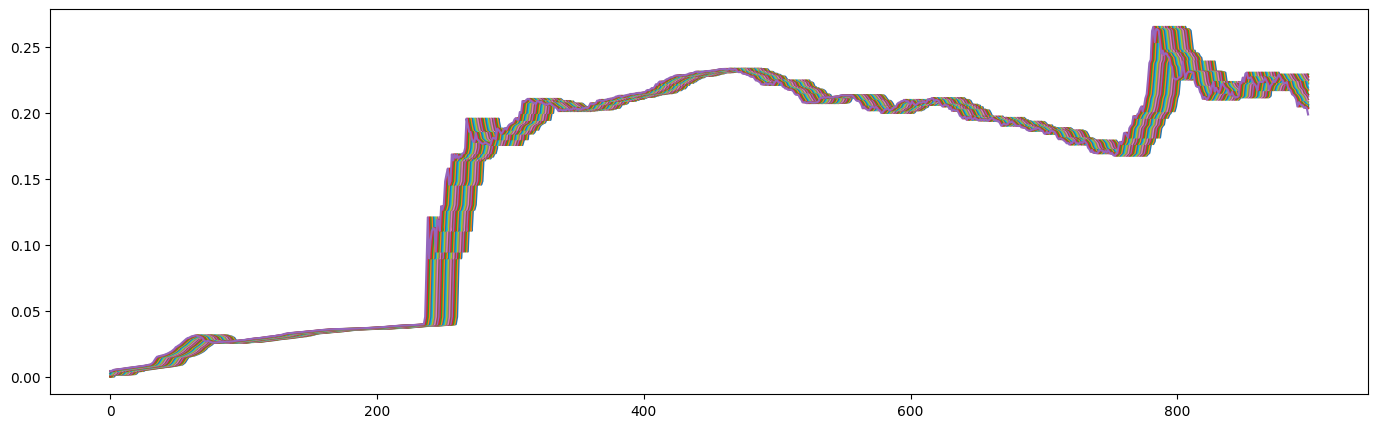

In [ ]:
plt.plot(x_train[:,0,:])
#plt.plot(x_test[:,0,:])

In [ ]:
look_back = 25
model = Sequential()
model.add(LSTM(40, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=17, batch_size=1, verbose=2)

Epoch 1/17


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


899/899 - 4s - 4ms/step - loss: 6.9488e-04
Epoch 2/17
899/899 - 1s - 2ms/step - loss: 8.4592e-05
Epoch 3/17
899/899 - 4s - 4ms/step - loss: 5.0047e-05
Epoch 4/17
899/899 - 4s - 4ms/step - loss: 4.9225e-05
Epoch 5/17
899/899 - 3s - 3ms/step - loss: 5.1834e-05
Epoch 6/17
899/899 - 1s - 2ms/step - loss: 4.2294e-05
Epoch 7/17
899/899 - 1s - 2ms/step - loss: 4.2956e-05
Epoch 8/17
899/899 - 2s - 2ms/step - loss: 4.1417e-05
Epoch 9/17
899/899 - 2s - 3ms/step - loss: 3.8168e-05
Epoch 10/17
899/899 - 2s - 2ms/step - loss: 3.3162e-05
Epoch 11/17
899/899 - 2s - 2ms/step - loss: 3.6574e-05
Epoch 12/17
899/899 - 2s - 2ms/step - loss: 3.2551e-05
Epoch 13/17
899/899 - 1s - 2ms/step - loss: 3.1050e-05
Epoch 14/17
899/899 - 2s - 2ms/step - loss: 3.3014e-05
Epoch 15/17
899/899 - 1s - 2ms/step - loss: 2.9949e-05
Epoch 16/17
899/899 - 2s - 2ms/step - loss: 2.6682e-05
Epoch 17/17
899/899 - 3s - 3ms/step - loss: 2.8883e-05


In [ ]:
lstm_predictions = model.predict(np.expand_dims(x_test, axis=-1))
lstm_predictions = scaler.inverse_transform(lstm_predictions)

testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(x_test[:,:,0]), lstm_predictions[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test Score: 9.09 RMSE


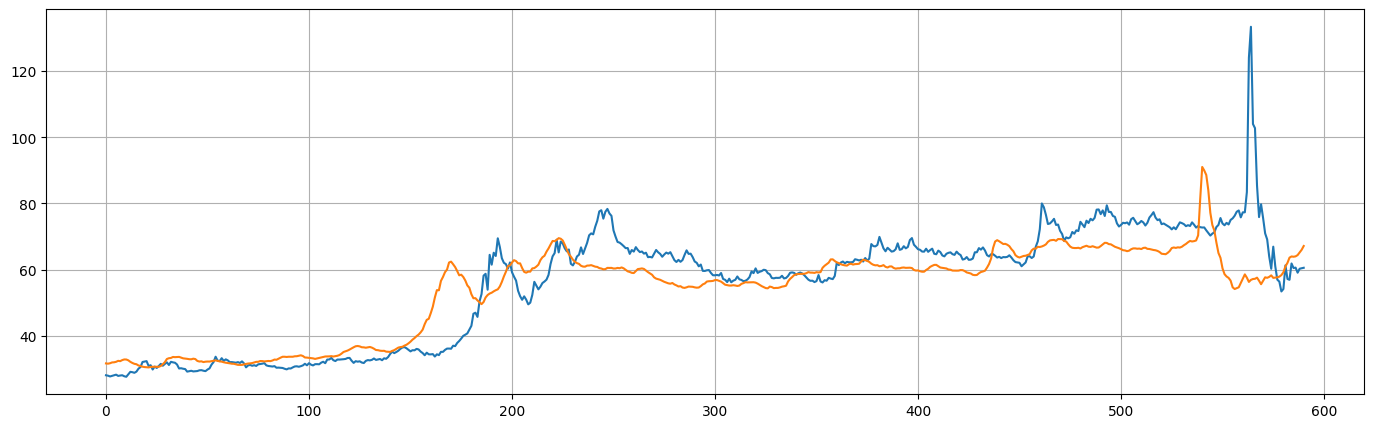

In [ ]:
plt.plot(scaler.inverse_transform(x_test[:,:,0]))
plt.plot(lstm_predictions)
plt.grid()
plt.show()

# Prediction model - ARIMA

In [11]:
from statsmodels.tsa.arima.model import ARIMA

In [12]:
train_size = int(len(df_close) * 0.6)
train_data, test_data = df_close[:train_size], df_close[train_size:]

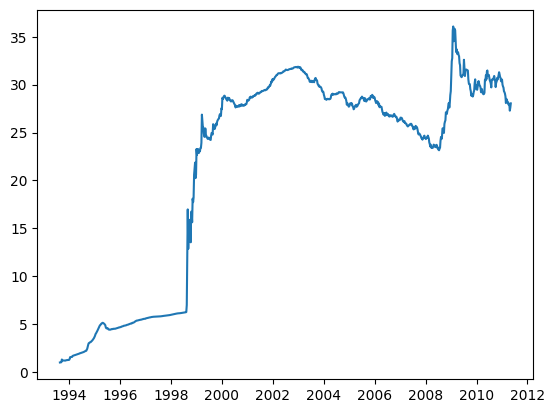

In [13]:
plt.plot(train_data)

The P value is defined as the probability under the assumption of no effect or no difference (null hypothesis), of obtaining a result equal to or more extreme than what was actually observed. The P stands for probability and measures how likely it is that any observed difference between groups is due to chance.

**Dickey–Fuller test** tests the null hypothesis that a unit root is present in an autoregressive (AR) time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, title=''):
    print(f"Results of ADF Test on {title}:")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Timeseries is non-stationary")
    else:
        print("Timeseries is stationary")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    print("\n")

test_stationarity(train_data, 'Counts')

Results of ADF Test on Counts:
ADF Statistic: -1.8500120248286613
p-value: 0.3559297136490945
Timeseries is non-stationary
Critical Value (1%): -3.4375643702748078
Critical Value (5%): -2.8647248254388096
Critical Value (10%): -2.568465808810804




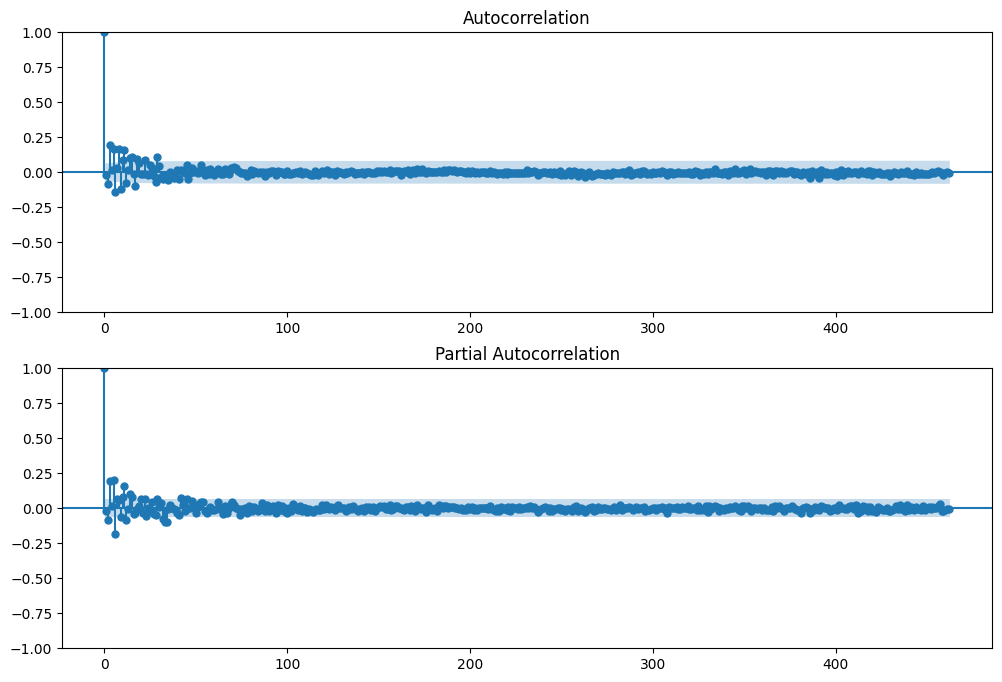

In [19]:
#Отрисовка ACF и PACF
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf


diff1 = train_data.diff()
diff1.dropna(inplace=True) #delete all rows with NaN value

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
half_size = len(diff1) // 2
fig = plot_acf(diff1, lags=half_size, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1, lags=half_size, ax=ax2)

Модель ARIMA(p,d,q) - интегрированная модель авторегрессии — скользящего среднего

\begin{equation}
a(L)(1-L)^{d} y_{t}=\alpha+b(L) \varepsilon_{t}
\end{equation}

где ε(t) — белый шум, L — оператор сдвига.


In [22]:
!pip install optuna --quiet

In [25]:
import optuna
import itertools

In [63]:
p = q = range(1, 40)
d = range(1, 5)
pdq = list(itertools.product(p, d, q))


def objective_arima(trial):
    order=trial.suggest_categorical('order',pdq)
    model=ARIMA(train_data['Close'].values,order=order)
    mdl = model.fit() #disp=0
    predictions = mdl.forecast(len(test_data))
    predictions = pd.Series(predictions.values, index=test_data.index)
    # predictions
    residuals = test_data['Close'].values - predictions
    mse=np.sqrt(np.mean(residuals**2))
    accuracy=mse
    return accuracy


In [ ]:
study=optuna.create_study(direction="minimize")
study.optimize(objective_arima,n_trials=1)

In [50]:
# 15 lags for autoregression (AR)
# 1st order differencing (I)
# No moving average term (MA)
arima_model = ARIMA(train_data['Close'].values, order=(31, 3, 22))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  925
Model:               ARIMA(31, 3, 22)   Log Likelihood                -449.579
Date:                Fri, 01 Nov 2024   AIC                           1007.157
Time:                        10:20:19   BIC                           1267.791
Sample:                             0   HQIC                          1106.606
                                - 925                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8419     17.609     -0.105      0.917     -36.355      32.671
ar.L2         -2.3123     29.900     -0.077      0.938     -60.916      56.291
ar.L3         -2.4224     35.545     -0.068      0.9

In [51]:
# ARIMA
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


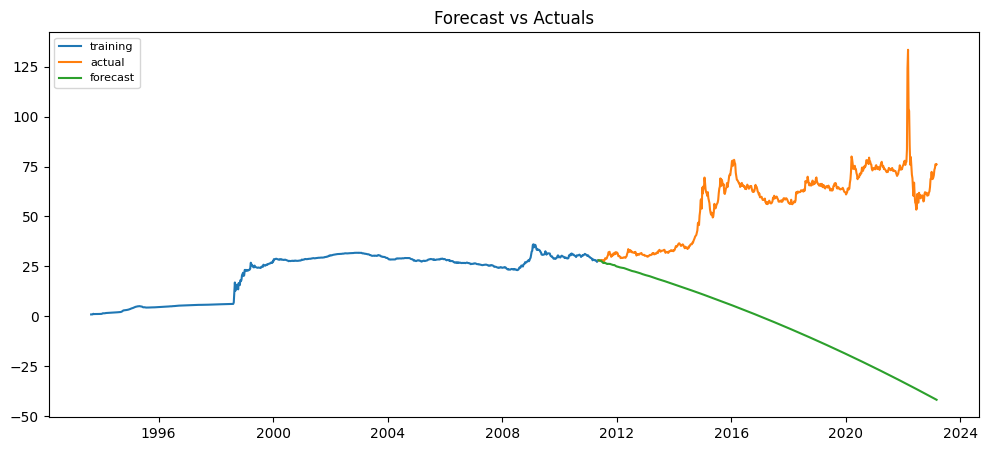

In [52]:
# Forecast
fc = arima_model_fit.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

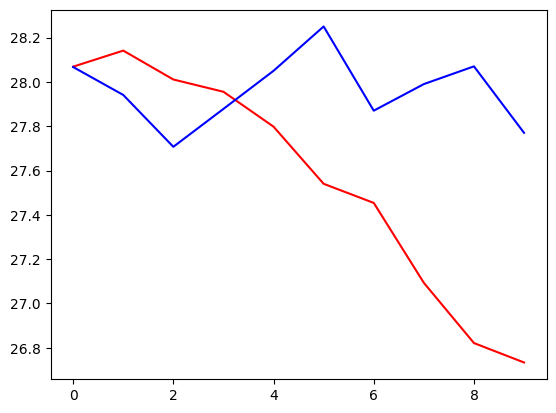

In [62]:
plt.plot(fc[:10],'r')
plt.plot(test_data.values[:10],'b')
plt.show()